<a id='top-page'></a>
# <img src="../images/PCAfold-logo.svg" style="height:100px"> Global and local PCA

In this tutorial, we present how global and local PCA can be performed on a
synthetic data set using the ``reduction`` module.

### PCA and LPCA functionalities

- [**Generate a synthetic data set for global PCA**](#data-set-global)
    - [**Global PCA**](#global-pca)
- [**Generate a synthetic data set for local PCA**](#data-set-local)
    - [**Cluster the data set for local PCA**](#clustering)
    - [**Local PCA**](#local-pca)
- [**Plotting global versus local PCA**](#plotting)

***

**Should plots be saved?**

In [1]:
save_plots = False

***

We import the necessary modules:

In [2]:
from PCAfold import preprocess
from PCAfold import reduction
from PCAfold import PCA, LPCA
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import ListedColormap
import numpy as np

and we set some initial parameters:

In [3]:
n_points = 1000
save_filename = None
global_color = '#454545'
k1_color = '#0e7da7'
k2_color = '#ceca70'
color_map = ListedColormap([k1_color, k2_color])

***
<a id='data-set-global'></a>
## Generate a synthetic data set for global PCA

[**↑ Go to the top**](#top-page)

We generate a synthetic data set on which the global PCA will be performed. This data set is composed of a single cloud of points.

In [4]:
mean_global = [0,1]
covariance_global = [[3.4, 1.1], [1.1, 2.1]]

x_noise, y_noise = np.random.multivariate_normal(mean_global, covariance_global, n_points).T
y_global = np.linspace(0,4,n_points)
x_global = -(y_global**2) + 7*y_global + 4
y_global = y_global + y_noise
x_global = x_global + x_noise

Dataset_global = np.hstack((x_global[:,np.newaxis], y_global[:,np.newaxis]))

This data set can be seen below:

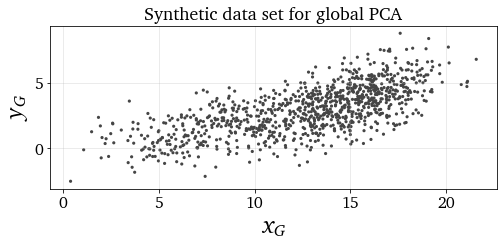

In [5]:
if save_plots == True: save_filename = '../images/tutorial-pca-data-set-for-global-pca.svg'
plt = reduction.plot_2d_manifold(x_global, y_global, x_label='$x_G$', y_label='$y_G$', color=global_color, title='Synthetic data set for global PCA', figure_size=(8,3), save_filename=save_filename)

<a id='global-pca'></a>
### Global PCA

[**↑ Go to the top**](#top-page)

We perform global PCA to obtain global principal components, global eigenvectors and global eigenvalues:

In [6]:
pca = PCA(Dataset_global, 'none', n_components=2)
principal_components_global = pca.transform(Dataset_global, nocenter=False)
eigenvectors_global = pca.A
eigenvalues_global = pca.L

We also retrieve the centered and scaled data set:

In [7]:
Dataset_global_pp = pca.X_cs

<a id='data-set-local'></a>
***

## Generate a synthetic data set for local PCA

[**↑ Go to the top**](#top-page)

Similarly, we generate another synthetic data set that is composed of two distinct clouds of points.

In [8]:
mean_local_1 = [0,1]
mean_local_2 = [6,4]
covariance_local_1 = [[2, 0.5], [0.5, 0.5]]
covariance_local_2 = [[3, 0.3], [0.3, 0.5]]

x_noise_1, y_noise_1 = np.random.multivariate_normal(mean_local_1, covariance_local_1, n_points).T
x_noise_2, y_noise_2 = np.random.multivariate_normal(mean_local_2, covariance_local_2, n_points).T
x_local = np.concatenate([x_noise_1, x_noise_2])
y_local = np.concatenate([y_noise_1, y_noise_2])

Dataset_local = np.hstack((x_local[:,np.newaxis], y_local[:,np.newaxis]))

This data set can be seen below:

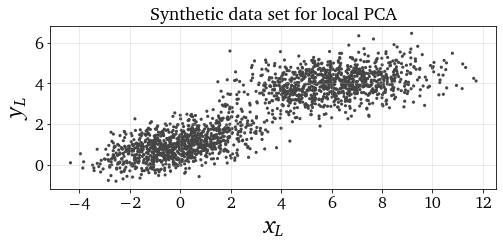

In [9]:
if save_plots == True: save_filename = '../images/tutorial-pca-data-set-for-local-pca.svg'
plt = reduction.plot_2d_manifold(x_local, y_local, x_label='$x_L$', y_label='$y_L$', color=global_color, title='Synthetic data set for local PCA', figure_size=(8,3), save_filename=save_filename)

<a id='clustering'></a>
### Cluster the data set for local PCA

[**↑ Go to the top**](#top-page)

We perform clustering of this data set based on pre-defined bins using the available ``preprocess.predefined_variable_bins`` function.
We obtain cluster classifications and centroids for each cluster:

In [10]:
(idx, borders) = preprocess.predefined_variable_bins(Dataset_local[:,0], [2.5], verbose=False)
centroids = preprocess.get_centroids(Dataset_local, idx)

The result of this clustering can be seen below:

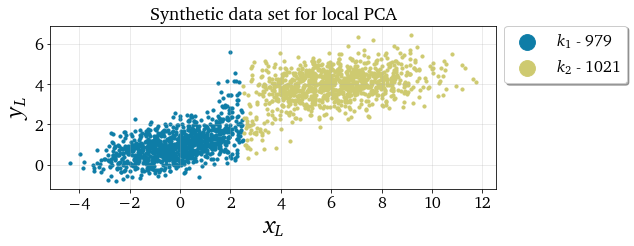

In [11]:
if save_plots == True: save_filename = '../images/tutorial-local-pca-clustering.svg'
plt = preprocess.plot_2d_clustering(x_local, y_local, idx, x_label='$x_L$', y_label='$y_L$', grid_on=True, color_map=color_map, title='Synthetic data set for local PCA', first_cluster_index_zero=False, figure_size=(8,3), save_filename=save_filename)

In local PCA, PCA is applied in each cluster separately.

<a id='local-pca'></a>
### Local PCA

[**↑ Go to the top**](#top-page)

We perform local PCA to obtain local principal components, local eigenvectors and local eigenvalues, tied to each of the two clusters:

In [12]:
lpca = LPCA(Dataset_local, idx, scaling='none')
principal_components_local = lpca.principal_components
eigenvectors_local = lpca.A
eigenvalues_local = lpca.L

<a id='plotting'></a>
***

## Plotting global versus local PCA

[**↑ Go to the top**](#top-page)

Finally, for the demonstration purposes, we plot the identified global and local eigenvectors on top of both synthetic data sets.
The visual result of performing PCA globally and locally can be seen below:

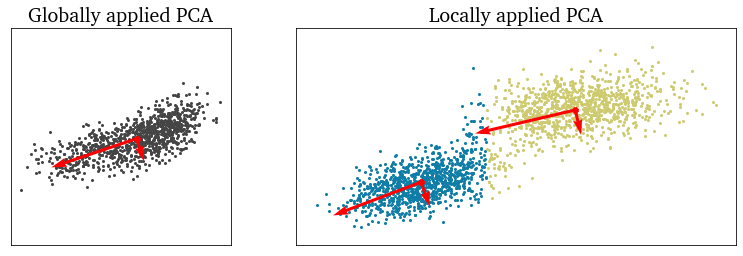

In [13]:
data_point = 4
font_text = 20
line_width = 1

figure = plt.figure(figsize=(13, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])

# First subplot - global PCA:
figureSubplot = plt.subplot(gs[0])
plt.scatter(Dataset_global_pp[:,0], Dataset_global_pp[:,1], s=data_point, color=global_color, marker='o', linewidth=line_width)

# Plot global eigenvectors:
plt.quiver(eigenvectors_global[0,0], eigenvectors_global[1,0], scale=30*(1-eigenvalues_global[0]), color='r', width=0.014)
plt.quiver(eigenvectors_global[0,1], eigenvectors_global[1,1], scale=10*(1-eigenvalues_global[1]), color='r', width=0.014)

plt.axis('equal')
plt.yticks([]), plt.xticks([])
plt.title('Globally applied PCA', fontsize=font_text)

# Plot global centroid:
plt.scatter(0, 0, color='r', marker='x', lineWidth=data_point, s=20);

# Second subplot - local PCA:
figureSubplot = plt.subplot(gs[1])
plt.scatter(Dataset_local[idx==0,0], Dataset_local[idx==0,1], s=data_point, c=k1_color, marker='o')
plt.scatter(Dataset_local[idx==1,0], Dataset_local[idx==1,1], s=data_point, c=k2_color, marker='o')

# Plot local eigenvectors:
origin = [centroids[0][0]], [centroids[0][1]]
plt.quiver(*origin, eigenvectors_local[0][0,0], eigenvectors_local[0][1,0], scale=30*(1-eigenvalues_local[0][0]), color='r', width=0.007)
plt.quiver(*origin, eigenvectors_local[0][0,1], eigenvectors_local[0][1,1], scale=20*(1-eigenvalues_local[0][1]), color='r', width=0.007)

origin = [centroids[1][0]], [centroids[1][1]]
plt.quiver(*origin, eigenvectors_local[1][0,0], eigenvectors_local[1][1,0], scale=30*(1-eigenvalues_local[1][0]), color='r', width=0.007)
plt.quiver(*origin, eigenvectors_local[1][0,1], eigenvectors_local[1][1,1], scale=20*(1-eigenvalues_local[1][1]), color='r', width=0.007)

plt.axis('equal')
plt.yticks([]), plt.xticks([])
plt.title('Locally applied PCA', fontsize=font_text)

# Plot local centroids:
plt.scatter(centroids[:, 0], centroids[:, 1], color='r', marker='x', lineWidth=data_point, s=20);

if save_plots==True: plt.savefig('../images/tutorial-pca-global-local-pca.svg', dpi = 500, bbox_inches='tight')

Note, that in local PCA, a separate set of eigenvectors is found in each cluster. The same goes for principal components and eigenvalues.

***